<a href="https://colab.research.google.com/github/sidrusiya/AILA_Tasks/blob/main/AILA_Task2_R2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import nltk
import re
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import seaborn as sns
import gensim
nltk.download('all')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
!pip3 install tensorflow_text
import tensorflow_text
!pip install -q tf-models-official
!pip install -q -U tensorflow-text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_hub as hub
import tensorflow_text as tf_text

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [4]:
dataset = open('/content/drive/MyDrive/nit_agartala_nlp_team_3.tsv', 'r')
df = pd.read_csv(dataset, sep='\t')

In [5]:
df.head()

,judge_id,id,sentence,relevance,lem_text,stem_text
0,1,1,Appeal by special leave from the order dated ...,0,appeal special leave order dated government pu...,appeal special leav order date govern punjab (...
1,2,1,From the Judgment and Order dated . . of the ...,0,judgment order dated . . bombay high court app...,judgment order date . . bombay high court appe...
2,3,1,Appeal from the judgment and decree dated rd/t...,0,appeal judgment decree dated rd/th calcutta hi...,appeal judgment decre date rd/th calcutta high...
3,4,1,of .,0,.,.
4,5,1,From the Judgment and order dated . . of the ...,0,judgment order dated . . allahabad high court ...,judgment order date . . allahabad high court c...


In [6]:
max_classes = len(df.relevance.unique())
max_length=128

In [7]:
!pip3 install transformers
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Same as before
checkpoint = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(checkpoint, max_length=max_length)

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 59 kB 6.6 MB/s 
     |████████████████████████████████| 3.3 MB 37.7 MB/s 
     |████████████████████████████████| 895 kB 38.5 MB/s 


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [8]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 3
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
batch_size = 32

# num_train_steps =  len((balanced_df.NumLabel) // batch_size) * EPOCHS
# lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
#                                end_learning_rate=0.,
#                                decay_steps=num_train_steps
#                                )

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=5e-5)

In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result = shuffle(df)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(result.sentence, result.relevance, 
                                                    test_size = 0.1, random_state = 42, stratify =result.relevance)

In [11]:
max_classes = len(df.relevance.unique())
print(max_classes)

2


In [12]:
%%time
encoded_labels_train = to_categorical(Y_train, num_classes=max_classes)
encoded_labels_test = to_categorical(Y_test, num_classes=max_classes)

CPU times: user 3.14 ms, sys: 5 µs, total: 3.14 ms
Wall time: 2.29 ms


In [13]:
def roberta_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in tqdm(range(len(data))):
      encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [14]:
!pip install tqdm
from tqdm import *
%time
train_inputs,train_attention_masks = roberta_encode(list(X_train), max_length)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.53 µs


  0%|          | 0/64972 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 64972/64972 [00:34<00:00, 1862.62it/s]


In [15]:
test_inputs,test_attention_masks = roberta_encode(list(X_test), max_length)

  0%|          | 0/7220 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 7220/7220 [00:03<00:00, 1852.21it/s]


In [16]:
print(f'Number of Samples in Training Set : {len(X_train)} Number of Samples in Validation Set: {len(X_test)} ')

Number of Samples in Training Set : 64972 Number of Samples in Validation Set: 7220 


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!mkdir checkpoints
filepath = "RoBERT-lemm-{epoch:02d}.h5"
MyCheckpoint = ModelCheckpoint(filepath,
                               monitor = 'val_categorical_accuracy',
                               verbose = 1,
                               save_best_only = True,
                               mode='auto',
                               save_weights_only = True)

MyEarlyStopping = EarlyStopping(patience =1,
                                monitor='val_categorical_accuracy',
                                restore_best_weights = True,
                                verbose = 1)

ModelSaver = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

In [18]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight(class_weight='balanced'
                                               ,classes=np.unique(df.relevance)
                                               ,y=df.relevance)

class_weights_array

array([0.64908022, 2.17694952])

In [19]:
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
class_weights

{0: 0.6490802179424934, 1: 2.176949520535553}

In [20]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa

# macro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='macro')
# micro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='micro')
# weighted_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='weighted')
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()
categorical_accuracry = tf.metrics.CategoricalAccuracy()

class F1_metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        # Initialize our metric by initializing the two metrics it's based on:
        # Precision and Recall
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update our metric by updating the two metrics it's based on
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        # To get the F1 result, we compute the harmonic mean of the current
        # precision and recall
        return 2 / ((1 / self.precision.result()) + (1 / self.recall.result())) 

F1Score = F1_metric()
metrics = [categorical_accuracry, F1Score]

In [21]:
def create_model(roberta_model):
  input_ids = tf.keras.Input(shape=(max_length,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')
  
  output = roberta_model([input_ids,attention_masks])
  output = output[1]
  
#   output = tf.keras.layers.Dense(128,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

#   output = tf.keras.layers.Dense(64,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)
  
  output = tf.keras.layers.Dense(units=max_classes,activation='softmax')(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)
  return model

In [22]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model = create_model(roberta_model)
model.summary()

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [23]:
%%time
history = model.fit([train_inputs,train_attention_masks], encoded_labels_train, 
                    validation_data=([test_inputs, test_attention_masks], encoded_labels_test),
                    epochs = EPOCHS,
                    batch_size = 32,
                    verbose = 1,
                    class_weight=class_weights,
                    callbacks = [MyCheckpoint, MyEarlyStopping]
                    )

Epoch 1/3
2031/2031 [==============================] - ETA: 0s - loss: 0.6934 - categorical_accuracy: 0.5380 - f1_score: 0.5380
Epoch 00001: val_categorical_accuracy improved from -inf to 0.22964, saving model to RoBERT-lemm-01.h5
2031/2031 [==============================] - 3061s 1s/step - loss: 0.6934 - categorical_accuracy: 0.5380 - f1_score: 0.5380 - val_loss: 0.6936 - val_categorical_accuracy: 0.2296 - val_f1_score: 0.2296
Epoch 2/3
2031/2031 [==============================] - ETA: 0s - loss: 0.6935 - categorical_accuracy: 0.2661 - f1_score: 0.2661
Epoch 00002: val_categorical_accuracy did not improve from 0.22964
Restoring model weights from the end of the best epoch: 1.
2031/2031 [==============================] - 3032s 1s/step - loss: 0.6935 - categorical_accuracy: 0.2661 - f1_score: 0.2661 - val_loss: 0.6935 - val_categorical_accuracy: 0.2296 - val_f1_score: 0.2296
Epoch 00002: early stopping
CPU times: user 34min 43s, sys: 11min 5s, total: 45min 48s
Wall time: 1h 41min 33s


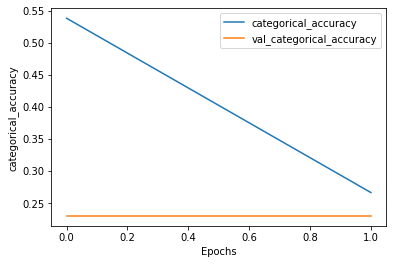

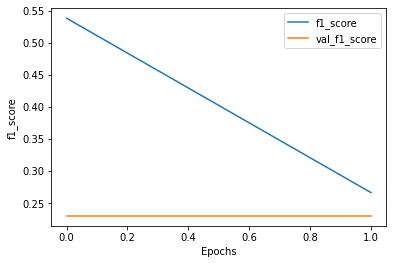

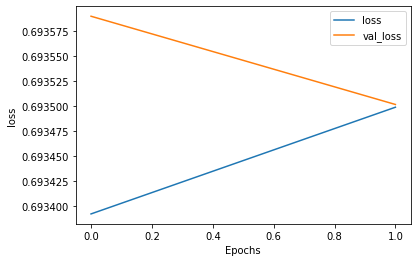

In [24]:
import matplotlib.pyplot as plt 
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "categorical_accuracy")
plot_graphs(history, "f1_score")
plot_graphs(history, 'loss')

In [25]:
import numpy as np
import pandas as pd
import os
import nltk
import re
import json

In [26]:
from google.colab import drive
drive.mount('/content/drive')
dataset1 = open('/content/drive/MyDrive/Task2_Test/aila_test_judgement.json', 'r')
data1 = json.load(dataset1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
yz1 = pd.DataFrame.from_dict(data1, orient='index')

In [28]:
yz1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104
1,"{'id': '1', 'sentence': 'From the Judgment and...","{'id': '2', 'sentence': 'W. P. numbers 2274, ...","{'id': '3', 'sentence': 'Rajinder Sachher and ...","{'id': '4', 'sentence': 'Harbans Lal, Dr. Mee...","{'id': '5', 'sentence': 'The Judgment of the C...","{'id': '6', 'sentence': 'These five appeals by...","{'id': '7', 'sentence': 'Writ Petition number ...","{'id': '8', 'sentence': 'Writ Peti tion number...","{'id': '9', 'sentence': 'Since identical conte...","{'id': '10', 'sentence': 'As it is said that C...","{'id': '11', 'sentence': 'Writ Petition number...","{'id': '12', 'sentence': 'The Bareilly Develop...","{'id': '13', 'sentence': 'as 'BDA'), the first...","{'id': '14', 'sentence': ', With a view to cas...","{'id': '15', 'sentence': 'The BDA issued' an a...","{'id': '16', 'sentence': 'In this appeal i. e....","{'id': '17', 'sentence': 'The following table ...","{'id': '18', 'sentence': 'HIG rupees 1500 and ...","{'id': '19', 'sentence': 'LIG rupees 351 to ru...","{'id': '20', 'sentence': 'EWS rupees 350 p. m....","{'id': '21', 'sentence': 'The note under the '...","{'id': '22', 'sentence': 'All the respondents ...","{'id': '23', 'sentence': 'their names' for MIG...","{'id': '24', 'sentence': 'Thereafter, the resp...","{'id': '25', 'sentence': '1. 84 from the Secre...","{'id': '26', 'sentence': 'Cost of the house ru...","{'id': '27', 'sentence': 'Down payment to be m...","{'id': '28', 'sentence': 'Rate of yearly inter...","{'id': '29', 'sentence': 'Amount of monthly in...","{'id': '30', 'sentence': '50 with interest.', ...","{'id': '31', 'sentence': 'By the said notice, ...","{'id': '32', 'sentence': 'Except the responden...","{'id': '33', 'sentence': 'Hence their names we...","{'id': '34', 'sentence': 'After allotment, the...","{'id': '35', 'sentence': 'dated 19/20.', 'rhet...","{'id': '36', 'sentence': '1. 1984, by a furthe...","{'id': '37', 'sentence': 'Similar notices were...","{'id': '38', 'sentence': 'On the above content...","{'id': '39', 'sentence': 'The above plea was r...","{'id': '40', 'sentence': 'It has been further ...",...,"{'id': '66', 'sentence': 'It may be mentioned ...","{'id': '67', 'sentence': 'The respondents exce...","{'id': '68', 'sentence': 'For a better appreci...","{'id': '69', 'sentence': 'I have seen the hous...","{'id': '70', 'sentence': 'I accept the rules o...","{'id': '71', 'sentence': '753 Only on the basi...","{'id': '72', 'sentence': 'In this connection, ...","{'id': '73', 'sentence': 'In this connection, ...","{'id': '74', 'sentence': '), B. Sc. , B. Ed. ,...","{'id': '75', 'sentence': 'From the above, it i...","{'id': '76', 'sentence': 'This is not only the...","{'id': '77', 'sentence': 'So it cannot be said...","{'id': '78', 'sentence': 'In such a circum sta...","{'id': '79', 'sentence': 'More so, the respond...","{'id': '80', 'sentence': '1. 84 are not justif...","{'id': '81', 'sentence': 'It is quite un-under...","{'id': '82', 'sentence': 'The respondents were...","{'id': '83', 'sentence': 'Notwithstanding, the...","{'id': '84', 'sentence': 'One should not loose...","{'id': '85', 'sentence': 'On the contrary, the...","{'id': '86', 'sentence': 'In fact, the respond...","{'id': '87', 'sentence': 'Thus the factual pos...","{'id': '88', 'sentence': 'In the case before u...","{'id': '89', 'sentence': 'When the factual pos...","{'id': '90', 'sentence': 'Therefore, the conte...","{'id': '91', 'sentence': 'Where an author ity ...","{'id': '92', 'sentence': 'This finding, in our...","{'id': '93', 'sentence': 'Even conceding that ...","{'id': '94', 'sentence': 'Thereafter the relat...","{'id': '95', 'sentence': 'In this sphere, they...","{'id': '96', 'sentence': 'There is a line of d...","{'id': '97', 'sentence': 'In view of the autho...","{'id': '98'

In [29]:
test_file= pd.DataFrame(columns=['judge_id', 'id', 'sentence'])
for i in range(105):
  for j in range(50):
    if yz1[i][j] is not None:
      test_file= test_file.append({'judge_id': j+1, 'id': yz1[i][j]['id'], 'sentence': yz1[i][j]['sentence']}, ignore_index=True)

In [ ]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result

In [ ]:
test_file['rel_sum']=test_file['sentence']
import sys
text = []
lem_text = []
for i in test_file.index:
    test_file['sentence'][i] = remove_size(test_file['sentence'][i])
    test_file['sentence'][i] = remove_months(test_file['sentence'][i])
    test_file['sentence'][i] = remove_nums(test_file['sentence'][i])
    test_file['sentence'][i] = remove_comma(test_file['sentence'][i])
    temp = test_file['sentence'][i].lower().split()
    clean = [word for word in temp if word not in stopwords.words('english')]
    clean = " ".join(clean)
    text.append(clean)
    lem_text.append(clean)

In [ ]:
for i in range(len(text)):
    text[i] = text[i].split()

In [ ]:
for i in range(len(lem_text)):
    lem_text[i] = lem_text[i].split()

In [ ]:
from nltk import PorterStemmer
st = PorterStemmer()
for i in range(len(text)):
    text[i] = [st.stem(word) for word in text[i]]

In [ ]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

for i in range(len(lem_text)):
    lem_text[i] = [lemmatizer.lemmatize(word) for word in lem_text[i]]

In [36]:
for i in range(len(text)):
    text[i] = " ".join(text[i])

text[0]

'judgment order date . . alla habad high court civil misc.'

In [ ]:
for i in range(len(lem_text)):
    lem_text[i] = " ".join(lem_text[i])

lem_text[0]

In [ ]:
test_file['lem_text'] = np.array(lem_text)
test_file['stem_text'] = np.array(text)

test_file

In [39]:
model.load_weights('./RoBERT-lemm-01.h5')
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.lem_text), max_length)
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

test_file['pred-labels-cleaned-e1'] = y_preds

  0%|          | 0/5066 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 5066/5066 [00:02<00:00, 2454.17it/s]


In [ ]:
model.load_weights('./RoBERT-lemm-02.h5')
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.lem_text), max_length)
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

test_file['pred-labels-cleaned-e2'] = y_preds

In [ ]:
model.load_weights('./RoBERT-lemm-03.h5')
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.lem_text), max_length)
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

test_file['pred-labels-cleaned-e3'] = y_preds